# Trace Clustering in Process Mining

## Importing librarires

In [2]:
import pm4py
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import warnings
warnings.simplefilter("ignore")

In [3]:
from pm4py.objects.log.log import EventLog


## Importing log
Importing event log of RoadTraffic. It is in XES format with 51 traces.

In [49]:
# Importing a XES event log
from pm4py.objects.log.importer.xes import importer as xes_importer
log = xes_importer.apply('DataSets/roadtraffic50traces.xes')
#log[1],type(log)

parsing log, completed traces :: 100%|██████████| 51/51 [00:00<00:00, 2438.19it/s]


## Petrinet from Alpha miner on complete log

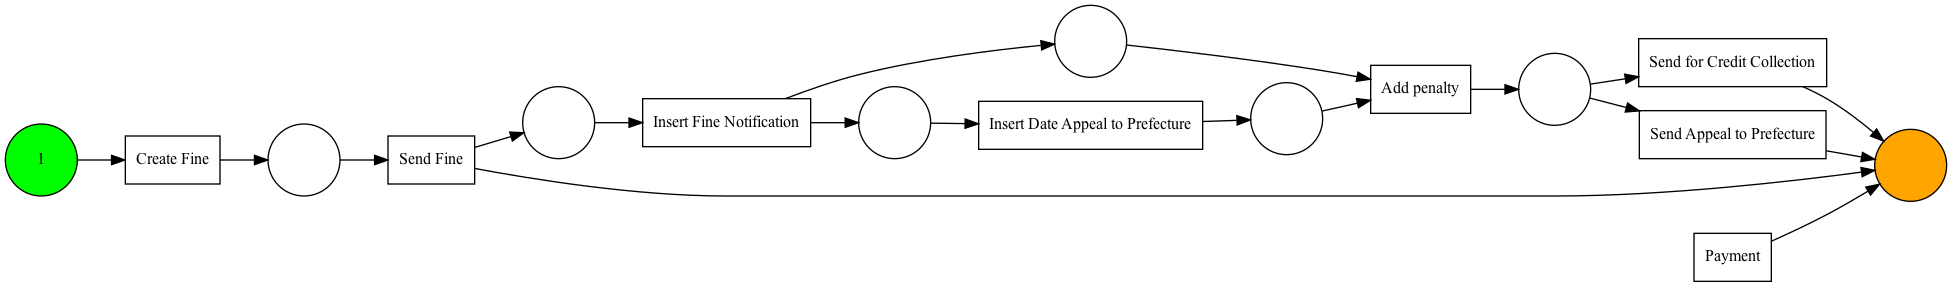

In [5]:
## Import the petrinet visualizer object
from pm4py.algo.discovery.alpha import algorithm as alpha_miner
net, initial_marking, final_marking = alpha_miner.apply(log)
from pm4py.visualization.petrinet import visualizer as pn_visualizer
# Visualise 
gviz = pn_visualizer.apply(net, initial_marking, final_marking) 
pn_visualizer.view(gviz)

## Log Fitness

In [6]:
from pm4py.algo.discovery.alpha import algorithm as alpha_miner
net, im, fm = alpha_miner.apply(log)
from pm4py.algo.evaluation.replay_fitness import algorithm as replay_fitness_evaluator
fitness = replay_fitness_evaluator.apply(log, net, im, fm, variant=replay_fitness_evaluator.Variants.TOKEN_BASED)
from pm4py.algo.evaluation.precision import algorithm as precision_evaluator
prec = precision_evaluator.apply(log, net, im, fm, variant=precision_evaluator.Variants.ETCONFORMANCE_TOKEN)
#prec
#fitness, type(fitness)
print('Fitness of log is: ', fitness['log_fitness']*100,'%')
print('Precision of log is: ', prec*100,'%')

replaying log with TBR, completed variants :: 100%|██████████| 7/7 [00:00<00:00, 1519.75it/s]

Fitness of log is:  79.66501785227098 %
Precision of log is:  64.98516320474778 %


### Extracting total Activities

In [61]:
from pm4py.algo.filtering.log.attributes import attributes_filter
activities = attributes_filter.get_attribute_values(log, "concept:name")
#resources = attributes_filter.get_attribute_values(log, "org:resource")
#activities

### Converting activity keys in to a list

In [60]:
activities_array = activities.keys()
activities_array = list(activities_array)
#activities_array


### Getting activities of each Trace in a Dataframe

In [51]:
## Converting log in to a pandas dataframe
from pm4py.objects.conversion.log import converter as log_converter
dataframe = log_converter.apply(log, variant=log_converter.Variants.TO_DATA_FRAME)
#dataframe.to_csv('log.csv')
#dataframe
## Trace profiling on Activities
dataframe =dataframe[['case:concept:name','concept:name']]
#dataframe

,case:concept:name,concept:name
0,A1,Create Fine
1,A1,Send Fine
2,A100,Create Fine
3,A100,Send Fine
4,A100,Insert Fine Notification
...,...,...
196,A10075,Create Fine
197,A10075,Send Fine
198,A10075,Insert Fine Notification
199,A10075,Add penalty


### Making np_array from Dataframe and grouping them on the basis of case identifier

In [63]:
np_arr = np.array(dataframe)
#np_arr
n = np.unique(np_arr[:,0])
events = np.array( [(np_arr[np_arr[:,0]==i,1]) for i in n] )
#events

## 2d Vector of Number of CASES X Number of Activities ( 51 traces and 8 total activities)

In [65]:
length  = len(log)
width = len(activities)
length,width
vectors  = [ [0] * width for _ in range(length)]
#type(vectors),len(vectors)
#vectors

## Activities Profiling - Updating Vector with the count of occurence of Activities

In [67]:
for i in range(len(events)):
        for j in range(len(events[i])):
                if events[i][j] == activities_array[0]:
                    vectors[i][0] += 1
                elif events[i][j] == activities_array[1]:
                    vectors[i][1] += 1
                elif events[i][j] == activities_array[2]:
                    vectors[i][2] += 1
                elif events[i][j] == activities_array[3]:
                    vectors[i][3] += 1
                elif events[i][j] == activities_array[4]:
                    vectors[i][4] += 1
                elif events[i][j] == activities_array[5]:
                    vectors[i][5] += 1
                elif events[i][j] == activities_array[6]:
                    vectors[i][6] += 1
                elif events[i][j] == activities_array[7]:
                    vectors[i][7] += 1
                

### Making ND-Array of the Activity Vector

In [69]:
np_vectors = np.array(vectors)
#np_vectors

## Elbow Method to find optimal number of clusters

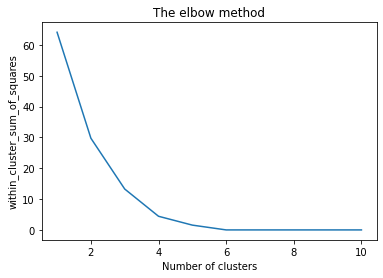

In [70]:
#  Elbow Method 
from sklearn.cluster import KMeans
within_cluster_sum_of_squares = []

for i in range(1, 11):
    kmeans = KMeans(n_clusters = i, init = 'k-means++', max_iter = 300, n_init = 10, random_state = 0)
    kmeans.fit(np_vectors)
    within_cluster_sum_of_squares.append(kmeans.inertia_)
    
#Plotting the results onto a line graph, allowing us to observe 'The elbow'
plt.plot(range(1, 11), within_cluster_sum_of_squares)
plt.title('The elbow method')
plt.xlabel('Number of clusters')
plt.ylabel('within_cluster_sum_of_squares') #within cluster sum of squares
plt.show()

# KMeans - Euclidean

In [71]:
from sklearn.cluster import KMeans
import numpy as np

kmeans = KMeans(n_clusters=3, random_state=0).fit(np_vectors)
kmeans.labels_
clustered  = kmeans.predict(np_vectors)
clustered


array([1, 0, 2, 0, 0, 1, 1, 0, 2, 0, 0, 0, 1, 0, 2, 0, 0, 0, 1, 0, 1, 0,
       0, 1, 1, 2, 0, 1, 2, 2, 0, 1, 0, 1, 1, 0, 1, 1, 1, 1, 1, 2, 0, 0,
       0, 2, 2, 0, 1, 1, 0], dtype=int32)

## Array of Sizes of clustered Data

In [72]:
count_arr = np.bincount(clustered)
print(count_arr)


[23 19  9]


## Creating Sub Event Logs based on Clustering Output

In [73]:
length1  = count_arr[0]
length2 = count_arr[1]
length3 = count_arr[2]

sub_log1 = EventLog()
sub_log2 = EventLog()
sub_log3 = EventLog()

for i in range(len(clustered)):
    if clustered[i] == 0:
        sub_log1.append(log[i])
    
    elif clustered[i] == 1:
        sub_log2.append(log[i])
        
    elif clustered[i] == 2: 
        sub_log3.append(log[i])

# Petrinets from Alpha miner on Sub Event Logs

## Petrinets from Alpha miner on Sub Event Log1

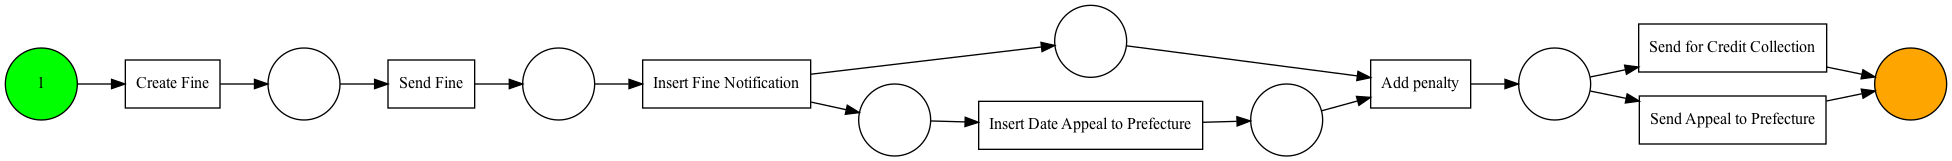

In [74]:

## Import the petrinet visualizer object
from pm4py.algo.discovery.alpha import algorithm as alpha_miner
net, initial_marking, final_marking = alpha_miner.apply(sub_log1)
from pm4py.visualization.petrinet import visualizer as pn_visualizer
# Visualise 
gviz = pn_visualizer.apply(net, initial_marking, final_marking) 
pn_visualizer.view(gviz)

## Log Fitness and Precision of SubLog1

In [82]:
from pm4py.algo.discovery.alpha import algorithm as alpha_miner
from pm4py.algo.evaluation.replay_fitness import algorithm as replay_fitness_evaluator
from pm4py.algo.evaluation.precision import algorithm as precision_evaluator
from pm4py.algo.evaluation.simplicity import algorithm as simplicity_evaluator
net, im, fm = alpha_miner.apply(sub_log1)
fitness = replay_fitness_evaluator.apply(sub_log1, net, im, fm, variant=replay_fitness_evaluator.Variants.TOKEN_BASED)
simp = simplicity_evaluator.apply(net)
prec = precision_evaluator.apply(sub_log1, net, im, fm, variant=precision_evaluator.Variants.ETCONFORMANCE_TOKEN)
print('Fitness of Petrinet is: ', fitness['log_fitness']*100,'%')
print('Precision of Petrinet is: ', prec*100,'%')
print('Simplicity of Petrinet is: ', simp*100,'%')
#prec

replaying log with TBR, completed variants :: 100%|██████████| 6/6 [00:00<00:00, 1546.76it/s]

Fitness of log is:  86.41975308641976 %
Precision of log is:  98.94736842105263 %
Simplicity of log is:  88.23529411764706 %


## Petrinets from Alpha miner on Sub Event Log2

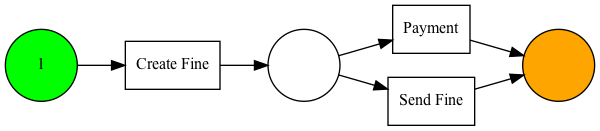

In [89]:

## Import the petrinet visualizer object
from pm4py.algo.discovery.alpha import algorithm as alpha_miner
net, initial_marking, final_marking = alpha_miner.apply(sub_log2)
from pm4py.visualization.petrinet import visualizer as pn_visualizer
# Visualise 
gviz = pn_visualizer.apply(net, initial_marking, final_marking) 
pn_visualizer.view(gviz)

## Log Fitness and Precision of SubLog2

In [90]:

net, im, fm = alpha_miner.apply(sub_log2)
fitness = replay_fitness_evaluator.apply(sub_log2, net, im, fm, variant=replay_fitness_evaluator.Variants.TOKEN_BASED)
simp = simplicity_evaluator.apply(net)
prec = precision_evaluator.apply(sub_log2, net, im, fm, variant=precision_evaluator.Variants.ETCONFORMANCE_TOKEN)
print('Fitness of Petrinet is: ', fitness['log_fitness']*100,'%')
print('Precision of Petrinet is: ', prec*100,'%')
print('Simplicity of Petrinet is: ', simp*100,'%')
#prec

replaying log with TBR, completed variants :: 100%|██████████| 2/2 [00:00<00:00, 563.07it/s]

Fitness of Petrinet is:  100.0 %
Precision of Petrinet is:  100.0 %
Simplicity of Petrinet is:  100.0 %


## Petrinets from Alpha miner on Sub Event Log3

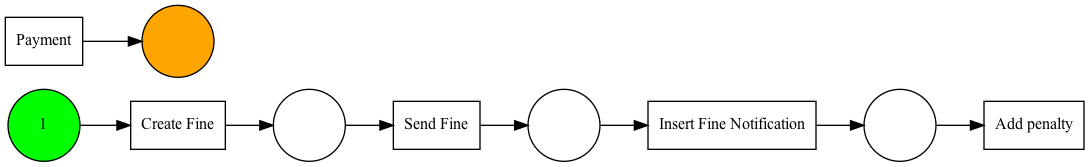

In [93]:

## Import the petrinet visualizer object
from pm4py.algo.discovery.alpha import algorithm as alpha_miner
net, initial_marking, final_marking = alpha_miner.apply(sub_log3)
from pm4py.visualization.petrinet import visualizer as pn_visualizer
# Visualise 
gviz = pn_visualizer.apply(net, initial_marking, final_marking) 
pn_visualizer.view(gviz)

## Log Fitness and Precision of Sub event log

In [94]:
net, im, fm = alpha_miner.apply(sub_log3)
fitness = replay_fitness_evaluator.apply(sub_log3, net, im, fm, variant=replay_fitness_evaluator.Variants.TOKEN_BASED)
simp = simplicity_evaluator.apply(net)
prec = precision_evaluator.apply(sub_log3, net, im, fm, variant=precision_evaluator.Variants.ETCONFORMANCE_TOKEN)
print('Fitness of Petrinet is: ', fitness['log_fitness']*100,'%')
print('Precision of Petrinet is: ', prec*100,'%')
print('Simplicity of Petrinet is: ', simp*100,'%')

replaying log with TBR, completed variants :: 100%|██████████| 5/5 [00:00<00:00, 1748.94it/s]

Fitness of Petrinet is:  97.87234042553192 %
Precision of Petrinet is:  56.62650602409638 %
Simplicity of Petrinet is:  100.0 %
